In [1]:
%matplotlib inline

import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
from cselect import color as cs
import sys
sys.path.insert(0,'../')
sys.path.insert(0,'../samples')
from mvpose.data import epfl_campus
from time import time

root = Settings['data_root']
root = join(root, 'pak')
tmp = Settings['tmp']

import mvpose.data.kth_football2 as kth
from mvpose import pose
from mvpose.settings import get_settings
from paf_loader import Loader
from mvpose.evaluation import pcp

import mvpose.data.skeleton_augmentation as ska
model_path = '../data/model_poseprediction.h5'
gen = ska.LimbGenerator(model_path, 1000)

/home/tanke/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
loader = Loader()

def generate_pcp_score(frame, params):
    global loader, gen
    alpha = 0.5
    
    Im, Y, Calib = epfl_campus.get(root, frame)
    heatmaps, pafs = loader.load_confidence_map_and_paf(
        'campus', Im, frame, dir=Settings['tmp'])
    detections = pose.estimate(Calib, heatmaps, pafs, 
                               settings=params, debug=False)
    #detections = gen.apply(detections)
    Humans = kth.transform3d_from_mscoco(detections)
    
    L_Arms = []
    U_Arms = []
    L_Legs = []
    U_Legs = []
    GTIDs = []
  
    for gtid, gt in enumerate(Y):
        if gt is None:
            continue
        
        larms = 0
        uarms = 0
        llegs = 0
        ulegs = 0
        avg = 0
        for d in Humans:
            r = pcp.evaluate(gt, d, alpha)
            larms_ = r.lower_arms
            uarms_ = r.upper_arms
            ulegs_ = r.upper_legs
            llegs_ = r.lower_legs
            avg_ = (larms_ + uarms_ + ulegs_ + llegs_) / 4
            if avg_ > avg:
                avg = avg_
                larms = larms_
                uarms = uarms_
                llegs = llegs_
                ulegs = ulegs_
        
        L_Arms.append(larms)
        U_Arms.append(uarms)
        L_Legs.append(llegs)
        U_Legs.append(ulegs)
        GTIDs.append(gtid)
    del heatmaps
    del pafs
    del detections
    del Im
    del Y
    del Calib
    
    return L_Arms, U_Arms, L_Legs, U_Legs, GTIDs

# ======================================
# RUN
# ======================================

# MEAN SHIFT

# ms_radius = [10, 20, 30, 40, 50, 60, 70, 90, 110, 120, 130, 140]
# ms_between_distances = [10, 30, 50, 60, 70, 90, 110, 120, 130, 150]

# for radius in ms_radius:
#     for between_distance in ms_between_distances:
        
#         _START = time()
#         print('\n--- next step ---')
#         print('radius:', radius)
#         print('between_distance:', between_distance)
        
#         valid_frames = list(range(350, 470, 2)) + list(range(650, 750, 2))
#         params = get_settings(scale_to_mm=1000,
#                           hm_detection_threshold=0.05,
#                           pp_conflict_overlap=0.4,
#                           ms_radius=radius,
#                           ms_between_distance=between_distance)
        
        
#         PER_GTID = {}
#         TESTS.append(PER_GTID)
#         for frame in valid_frames:
#             _start = time()
#             L_Arms, U_Arms, L_Legs, U_Legs, GTIDs =\
#                 generate_pcp_score(frame, params)
#             _end = time()
#             print('frame ' + str(frame) + ', elapsed:', _end - _start)
#             if len(L_Arms) > 0:
#                 for gtid, larms, uarms, llegs, ulegs in zip(
#                     GTIDs, L_Arms, U_Arms, L_Legs, U_Legs
#                 ):
#                     if not gtid in PER_GTID:
#                         PER_GTID[gtid] = {
#                             'larms': [],
#                             'uarms': [],
#                             'llegs': [],
#                             'ulegs': [],
#                             'frame': []
#                         }
#                     PER_GTID[gtid]['larms'].append(larms)
#                     PER_GTID[gtid]['uarms'].append(uarms)
#                     PER_GTID[gtid]['llegs'].append(llegs)
#                     PER_GTID[gtid]['ulegs'].append(ulegs)
#                     PER_GTID[gtid]['frame'].append(frame)
#                     #AVG.append((larms + uarms + llegs + ulegs)/4)
#         _END = time()
#         print('total step ELAPSED:', _END - _START)

# i = 0

# IMG = np.zeros((len(ms_radius), len(ms_between_distances)), 'float32')

# for a, radius in enumerate(ms_radius):
#     for b, between_distance in enumerate(ms_between_distances):
#         print('radius:', radius)
#         print('between-distance:', between_distance)
#         total_avg = []
        
#         PER_GTID = TESTS[i]
#         i += 1
        
#         for key, values in PER_GTID.items():
#             avg = np.mean([
#                 np.mean(values['uarms']),
#                 np.mean(values['larms']),
#                 np.mean(values['ulegs']),
#                 np.mean(values['llegs'])
#             ])
#             total_avg.append(avg)
# #             print('\tavg:  ', avg)
#         print('\navg*:  ', np.mean(total_avg))
#         IMG[a,b] = np.mean(total_avg)
#         print('')

In [3]:
hm_detection_thresholds = [.01, .03, .05, .1, .2]
# pp_conflict_overlaps = [.2, .4, .6, .8]
# min_joint_distances = [0, 20, 40, 50, 70, 100, 150]

# ms_radius = [10, 20, 30, 40, 50, 60, 70, 90, 110, 120, 130, 140]
# ms_between_distances = [10, 30, 50, 60, 70, 90, 110, 120, 130, 150]

# radius/between
ms = [
    (60, 60),
    (50, 60),
    (40, 60),
    (30, 60),
    (20, 60),
    (60, 30),
    (60, 20),
    (120, 130)
]
# TESTS = []

# for th in hm_detection_thresholds:
#     for radius, between_distance in ms:
        
#         _START = time()
#         print('\n--- next step ---')
#         print('threshold:', th)
#         print('radius:', radius)
#         print('between_distance:', between_distance)
        
#         valid_frames = list(range(350, 470, 2)) + list(range(650, 750, 2))
#         params = get_settings(scale_to_mm=1000,
#                           hm_detection_threshold=th,
#                           pp_conflict_overlap=0.4,
#                           ms_radius=radius,
#                           ms_between_distance=between_distance)
        
        
#         PER_GTID = {}
#         TESTS.append(PER_GTID)
#         for frame in valid_frames:
#             _start = time()
#             L_Arms, U_Arms, L_Legs, U_Legs, GTIDs =\
#                 generate_pcp_score(frame, params)
#             _end = time()
#             #print('frame ' + str(frame) + ', elapsed:', _end - _start)
#             if len(L_Arms) > 0:
#                 for gtid, larms, uarms, llegs, ulegs in zip(
#                     GTIDs, L_Arms, U_Arms, L_Legs, U_Legs
#                 ):
#                     if not gtid in PER_GTID:
#                         PER_GTID[gtid] = {
#                             'larms': [],
#                             'uarms': [],
#                             'llegs': [],
#                             'ulegs': [],
#                             'frame': []
#                         }
#                     PER_GTID[gtid]['larms'].append(larms)
#                     PER_GTID[gtid]['uarms'].append(uarms)
#                     PER_GTID[gtid]['llegs'].append(llegs)
#                     PER_GTID[gtid]['ulegs'].append(ulegs)
#                     PER_GTID[gtid]['frame'].append(frame)
#                     #AVG.append((larms + uarms + llegs + ulegs)/4)
#         _END = time()
#         print('total step ELAPSED:', _END - _START)

        
# i = 0

# IMG = np.zeros((len(hm_detection_thresholds), len(ms)), 'float32')

# for a, th in enumerate(hm_detection_thresholds):
#     for b, meanshift in enumerate(ms):
#         print('threshold:', th)
#         print('radius/between_distance:', meanshift)
#         total_avg = []
        
#         PER_GTID = TESTS[i]
#         i += 1
        
#         for key, values in PER_GTID.items():
#             avg = np.mean([
#                 np.mean(values['uarms']),
#                 np.mean(values['larms']),
#                 np.mean(values['ulegs']),
#                 np.mean(values['llegs'])
#             ])
#             total_avg.append(avg)
# #             print('\tavg:  ', avg)
#         print('\navg*:  ', np.mean(total_avg))
#         IMG[a,b] = np.mean(total_avg)
#         print('')

In [4]:
#hm_detection_thresholds = [.01, .03, .05, .1, .2]
#pp_conflict_overlaps = [.2, .4, .6, .8]
# min_joint_distances = [0, 20, 40, 50, 70, 100, 150]

# ms_radius = [10, 20, 30, 40, 50, 60, 70, 90, 110, 120, 130, 140]
# ms_between_distances = [10, 30, 50, 60, 70, 90, 110, 120, 130, 150]

# radius/between
# ms = [
#     (60, 60),
#     (50, 60),
#     (40, 60),
#     (30, 60),
#     (20, 60),
#     (60, 30),
#     (60, 20),
#     (120, 130)
# ]
# TESTS = []

# for th in pp_conflict_overlaps:
#     for radius, between_distance in ms:
        
#         _START = time()
#         print('\n--- next step ---')
#         print('threshold:', th)
#         print('radius:', radius)
#         print('between_distance:', between_distance)
        
#         valid_frames = list(range(350, 470, 2)) + list(range(650, 750, 2))
#         params = get_settings(scale_to_mm=1000,
#                           hm_detection_threshold=0.03,
#                           pp_conflict_overlap=th,
#                           ms_radius=radius,
#                           ms_between_distance=between_distance)
        
        
#         PER_GTID = {}
#         TESTS.append(PER_GTID)
#         for frame in valid_frames:
#             _start = time()
#             L_Arms, U_Arms, L_Legs, U_Legs, GTIDs =\
#                 generate_pcp_score(frame, params)
#             _end = time()
#             #print('frame ' + str(frame) + ', elapsed:', _end - _start)
#             if len(L_Arms) > 0:
#                 for gtid, larms, uarms, llegs, ulegs in zip(
#                     GTIDs, L_Arms, U_Arms, L_Legs, U_Legs
#                 ):
#                     if not gtid in PER_GTID:
#                         PER_GTID[gtid] = {
#                             'larms': [],
#                             'uarms': [],
#                             'llegs': [],
#                             'ulegs': [],
#                             'frame': []
#                         }
#                     PER_GTID[gtid]['larms'].append(larms)
#                     PER_GTID[gtid]['uarms'].append(uarms)
#                     PER_GTID[gtid]['llegs'].append(llegs)
#                     PER_GTID[gtid]['ulegs'].append(ulegs)
#                     PER_GTID[gtid]['frame'].append(frame)
#                     #AVG.append((larms + uarms + llegs + ulegs)/4)
#         _END = time()
#         print('total step ELAPSED:', _END - _START)

        
# i = 0

# IMG = np.zeros((len(hm_detection_thresholds), len(ms)), 'float32')

# for a, th in enumerate(hm_detection_thresholds):
#     for b, meanshift in enumerate(ms):
#         print('threshold:', th)
#         print('radius/between_distance:', meanshift)
#         total_avg = []
        
#         PER_GTID = TESTS[i]
#         i += 1
        
#         for key, values in PER_GTID.items():
#             avg = np.mean([
#                 np.mean(values['uarms']),
#                 np.mean(values['larms']),
#                 np.mean(values['ulegs']),
#                 np.mean(values['llegs'])
#             ])
#             total_avg.append(avg)
# #             print('\tavg:  ', avg)
#         print('\navg*:  ', np.mean(total_avg))
#         IMG[a,b] = np.mean(total_avg)
#         print('')

In [5]:
# fig = plt.figure(figsize=(10, 12))
# ax = fig.add_subplot(111)

# heatmap = ax.pcolor(IMG)
# cbar = plt.colorbar(heatmap)

# plt.show()

min joint distance 0
avg*:   0.0


min joint distance 20
avg*:   0.8884631922944616


min joint distance 40
avg*:   0.8917730908152736


min joint distance 50
avg*:   0.890139103887169


min joint distance 70
avg*:   0.874874226006192


min joint distance 100
avg*:   0.8596276229790162


min joint distance 150
avg*:   0.752797127622979




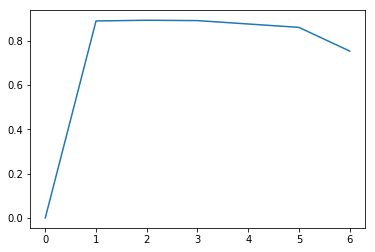

In [8]:
min_joint_distances = [0, 20, 40, 50, 70, 100, 150]

TESTS = []
for mj in min_joint_distances:            
    _START = time()
    print('\n--- next step ---')
    print('min joint distance:', mj)

    valid_frames = list(range(350, 470, 2)) + list(range(650, 750, 2))
    params = get_settings(scale_to_mm=1000,
                      hm_detection_threshold=0.05,
                      pp_conflict_overlap=0.4,
                      min_joint_distance=mj,
                      ms_radius=60,
                      ms_between_distance=60)


    PER_GTID = {}
    TESTS.append(PER_GTID)
    for frame in valid_frames:
        _start = time()
        L_Arms, U_Arms, L_Legs, U_Legs, GTIDs =\
            generate_pcp_score(frame, params)
        _end = time()
        #print('frame ' + str(frame) + ', elapsed:', _end - _start)
        if len(L_Arms) > 0:
            for gtid, larms, uarms, llegs, ulegs in zip(
                GTIDs, L_Arms, U_Arms, L_Legs, U_Legs
            ):
                if not gtid in PER_GTID:
                    PER_GTID[gtid] = {
                        'larms': [],
                        'uarms': [],
                        'llegs': [],
                        'ulegs': [],
                        'frame': []
                    }
                PER_GTID[gtid]['larms'].append(larms)
                PER_GTID[gtid]['uarms'].append(uarms)
                PER_GTID[gtid]['llegs'].append(llegs)
                PER_GTID[gtid]['ulegs'].append(ulegs)
                PER_GTID[gtid]['frame'].append(frame)
                #AVG.append((larms + uarms + llegs + ulegs)/4)
    _END = time()
    print('total step ELAPSED:', _END - _START)
    

RESULT = []
for i, mj in enumerate(min_joint_distances): 
    print('min joint distance', mj)
    PER_GTID = TESTS[i]
    
    total_avg = []
    for key, values in PER_GTID.items():
        avg = np.mean([
            np.mean(values['uarms']),
            np.mean(values['larms']),
            np.mean(values['ulegs']),
            np.mean(values['llegs'])
        ])
        total_avg.append(avg)
    print('avg*:  ', np.mean(total_avg))
    print('\n')
    RESULT.append(np.mean(total_avg))
    

plt.plot(range(len(RESULT)), RESULT)